In [19]:
%matplotlib inline
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Dropout, Input, Activation, Dense, dot, concatenate
from keras.layers import LSTM
import os
import numpy as np
import pandas as pd
import re
import IPython
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH = './babi_tasks/en-10k/qa1_single-supporting-fact_train.txt'
TEST_PATH = './babi_tasks/en-10k/qa1_single-supporting-fact_test.txt'
train_epochs = 100
batch_size = 32
lstm_units = 64

In [3]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [155]:
def parse_stories(lines):
    
    story=[]
    data = []
    for line in lines:
        nid,line = line.split(" ",1)
        nid = int(nid)
        if nid == 1:
            story = []
            
        if '\t' in line:
            q,a,support = line.split('\t')
            substory = None
            q = tokenize(q)
#             support = map(int, support.split())
#             substory = [story[i] for i in story]
#             story = list(np.array(story).T.tolist())
            story = np.array(story).T.tolist()
            
            data.append((story,q,a))
            
        else:
            sent = tokenize(line)
#             for i in sent:
            story+=sent
            
    return data

In [156]:
def vectorize(data, word_idx, story_maxlen, ques_maxlen):
    vec_story = []
    vec_ques = []
    vec_ans = []
    
    for story, ques, ans in data:
        st = []
        q = []
        
        for i in story:
            st.append(word_idx[i])
        
        for i in ques:
            q.append(word_idx[i])
            
        a =  np.zeros(len(word_idx))
        a[word_idx[ans]] = 1
        
        vec_story.append(st)
        vec_ques.append(q)
        vec_ans.append(a)
        
    return (pad_sequences(vec_story, maxlen = story_maxlen), pad_sequences(vec_ques, maxlen = ques_maxlen), np.array(vec_ans))

In [189]:
train = parse_stories(open(TRAIN_PATH, 'r'))

/usr/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [190]:
test = parse_stories(open(TEST_PATH, 'r'))

/usr/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [159]:
vocab = set()

for st, q, a in train+test:
    for i in st+q+[a]:
        vocab.add(i)
vocab = sorted(vocab)

In [160]:
vocab_size = len(vocab)

In [161]:
word_idx = {vocab[i]:i for i in range(len(vocab))}
idx_word = {i:vocab[i] for i in range(len(vocab))}

word_idx

{'.': 0,
 '?': 1,
 'Daniel': 2,
 'John': 3,
 'Mary': 4,
 'Sandra': 5,
 'Where': 6,
 'back': 7,
 'bathroom': 8,
 'bedroom': 9,
 'garden': 10,
 'hallway': 11,
 'is': 12,
 'journeyed': 13,
 'kitchen': 14,
 'moved': 15,
 'office': 16,
 'the': 17,
 'to': 18,
 'travelled': 19,
 'went': 20}

In [162]:
story_maxlen =max(map(len, (x for x,_,_ in train + test)))
ques_maxlen =max(map(len, (x for _,x,_ in train + test)))
print(story_maxlen, ques_maxlen)

68 4


In [163]:
train_sent, train_ques, train_ans = vectorize(train, word_idx, story_maxlen, ques_maxlen)
print(train_sent[0],  train_ques[0], train_ans[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 15 18 17  8
  0  3 20 18 17 11  0  2 20  7 18 17 11  0  5 15 18 17 10  0] [ 6 12  4  1] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [191]:
test_sent, test_ques, test_ans = vectorize(test, word_idx, story_maxlen, ques_maxlen)

In [192]:
print("shape of train stories:",np.array(train_sent).shape)
print("shape of train ques:",np.array(train_ques).shape)
print("shape of train answers:",np.array(train_ans).shape)
print()
print("shape of test stories:",np.array(test_sent).shape)
print("shape of test ques:",np.array(test_ques).shape)
print("shape of test answers:",np.array(test_ans).shape)

shape of train stories: (10000, 68)
shape of train ques: (10000, 4)
shape of train answers: (10000, 21)

shape of test stories: (1000, 68)
shape of test ques: (1000, 4)
shape of test answers: (1000, 21)


In [166]:
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

In [167]:
input_sentence = Input((story_maxlen,))
input_ques = Input((ques_maxlen,))

encoder_sent = Embedding(input_dim = vocab_size,output_dim = 64, input_length = story_maxlen)
encoder_ques = Embedding(input_dim = vocab_size,output_dim = 64, input_length = ques_maxlen)

encoded_sent = encoder_sent(input_sentence)
encoded_ques = encoder_ques(input_ques)

dot_layer = dot([encoded_sent, encoded_ques], axes = (2,2))
concat_layer = concatenate([encoded_sent, dot_layer])

answer = LSTM(lstm_units)(concat_layer)
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation("softmax")(answer)

In [168]:
model = Model([input_sentence, input_ques], answer)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [169]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 68, 64)       1344        input_9[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 4, 64)        1344        input_10[0][0]                   
__________________________________________________________________________________________________
dot_5 (Dot

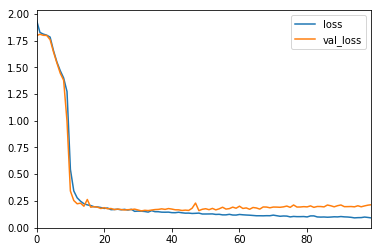

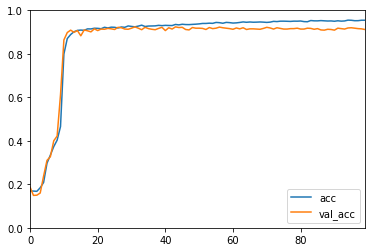

10000/10000 [==============================] - 26s 3ms/step - loss: 0.0898 - acc: 0.9546 - val_loss: 0.2135 - val_acc: 0.9120


In [170]:
model.fit([train_sent, train_ques], train_ans, batch_size, train_epochs,callbacks=[TrainingVisualizer()],
          validation_data=([test_sent, test_ques], test_ans))

In [172]:
model.save("model.h5")

In [182]:
for i in range(20):
    pred_vec = model.predict([np.array([test_sent[i]]), np.array([test_ques[i]])])
    print("Story:"," ".join(test[i][0]))
    print("Question: "," ".join(test[i][1]),"Answer: ", test[i][2])
    print("predicted: ",idx_word[np.argmax(pred_vec)])
    print()

Story: John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom .
Question:  Where is John ? Answer:  hallway
predicted:  hallway

Story: John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen .
Question:  Where is Mary ? Answer:  bathroom
predicted:  bathroom

Story: John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Sandra travelled to the hallway . John went to the garden .
Question:  Where is Sandra ? Answer:  kitchen
predicted:  kitchen

Story: John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Sandra travelled t

In [183]:
from keras.models import load_model
test_model = load_model('model.h5')

In [187]:
print("Custom input:")
while 1:
    inp_story = input("Story (provide spaces even before punctuation marks): ").split(' ')
    inp_ques = input("Question (provide spaces even before punctuation marks): ").split(' ')
    enc_story, enc_ques, _ = vectorize([[inp_story, inp_ques, "."]], word_idx, story_maxlen, ques_maxlen)
    pred = test_model.predict([enc_story, enc_ques])
    print("predicted: ",idx_word[np.argmax(pred)])

Custom input:
Story (provide spaces even before punctuation marks): John moved to the hallway . John journeyed to the kitchen . Sandra travelled to the garden . John journeyed to the garden . Daniel journeyed to the office . John went to the kitchen . Sandra journeyed to the hallway . Mary went to the hallway . Mary went to the kitchen . Sandra travelled to the garden .
Question (provide spaces even before punctuation marks): Where is John ?
predicted:  kitchen


KeyboardInterrupt: 